# predicting-lol-matches

# To setup the project, run the cells in the order of the title numbering.
## After the numbered cells have been run, any of the other cells can be run without problems.

## 1. Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from mlxtend.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
import math
import datetime
import itertools
import time
from collections import OrderedDict
from collections import defaultdict

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['figure.dpi'] = 100

def division_by_zero(x):
    if x == 0:
        return 1
    return x

positions = ['top', 'jgl', 'mid', 'adc', 'sup']

## 2. Functions for match processing and feature construction

In [2]:
def load_data(file):
    data_csv = os.path.join("", file)
    data = pd.read_csv(data_csv)
    return data


### Time Weighting Function

def time_weight(current_date, past_date, time_weight_constant):
    return math.exp((current_date-past_date).days * -time_weight_constant)



def process_matches(matches_data):
    matches_array = []
    for i in matches_data.index:
        team_data = matches_data.loc[i]
        
        if team_data['player_id'] == 100:
            next_team_data = matches_data.loc[i+1]
            
            data = OrderedDict()
            #data['url'] = team_data['url']
            data['game_id'] = team_data['game_id']
            data['date'] = team_data['date']
            data['region'] = team_data['region']
            data['tournament'] = team_data['tournament']
            data['series_length'] = team_data['series_length']
            data['game_in_series'] = team_data['game_in_series']
            data['blue_team'] = team_data['team'].lower()
            data['red_team'] = next_team_data['team'].lower()
            data['blue_win'] = bool(team_data['result'])
            
            data['blue_games_played'] = 0
            data['red_games_played'] = 0

            data['blue_top'] = team_data['top'].lower()
            data['blue_jgl'] = team_data['jgl'].lower()
            data['blue_mid'] = team_data['mid'].lower()
            data['blue_adc'] = team_data['adc'].lower()
            data['blue_sup'] = team_data['sup'].lower()
            data['red_top'] = next_team_data['top'].lower()
            data['red_jgl'] = next_team_data['jgl'].lower()
            data['red_mid'] = next_team_data['mid'].lower()
            data['red_adc'] = next_team_data['adc'].lower()
            data['red_sup'] = next_team_data['sup'].lower()

            data['blue_kills'] = team_data['kills']
            data['red_kills'] = next_team_data['kills']
            data['blue_deaths'] = team_data['deaths']
            data['red_deaths'] = next_team_data['deaths']

            data['blue_first_blood'] = team_data['first_blood']

            data['blue_first_tower'] = team_data['first_tower']

            data['blue_first_to_three_towers'] = team_data['first_to_three_towers']

            data['blue_first_dragon'] = team_data['first_dragon']

            data['blue_dragons'] = team_data['team_elementals']
            data['red_dragons'] = next_team_data['team_elementals']

            data['blue_first_baron'] = team_data['first_baron']

            data['blue_barons'] = team_data['team_barons']
            data['red_barons'] = next_team_data['team_barons']
            
            data['blue_heralds'] = team_data['herald']

            data['blue_gold_spent'] = team_data['gold_spent']
            data['red_gold_spent'] = next_team_data['gold_spent']

            data['blue_gold_at_15'] = team_data['gold_at_15']
            data['red_gold_at_15'] = next_team_data['gold_at_15']

            data['blue_wards_placed_per_minute'] = team_data['wards_placed_per_minute']
            data['red_wards_placed_per_minute'] = next_team_data['wards_placed_per_minute']

            data['blue_wards_cleared_per_minute'] = team_data['wards_cleared_per_minute']
            data['red_wards_cleared_per_minute'] = next_team_data['wards_cleared_per_minute']

            data['blue_damage_per_minute'] = team_data['damage_per_minute']
            data['red_damage_per_minute'] = next_team_data['damage_per_minute']

            data['blue_first_tower_gained_time'] = team_data['first_tower_gained_time']
            data['blue_first_tower_conceded_time'] = team_data['first_tower_conceded_time']

            data['blue_gold_at_25'] = team_data['gold_at_25']
            data['red_gold_at_25'] = next_team_data['gold_at_25']

            matches_array.append(data)

    matches = pd.DataFrame(matches_array)
    
    # manually remove series with missing games
    matches_to_drop = [801095, 801097]
    matches = matches[~matches['game_id'].isin(matches_to_drop)].reset_index(drop=True)
    
    # sets the date for a match as the date for the first game in the same series
    # needed for sorting games whose times overlap
    for i in matches.index:
        game_in_series = matches.loc[i]['game_in_series']
        matches.at[i, 'date'] = matches.loc[i - game_in_series + 1]['date']
    
    matches['date'] = pd.to_datetime(matches.date, unit='ms')
    # Resets index -> sorts using date followed by old index as criteria -> Resets index
    matches = matches.reset_index().sort_values(by=['date', 'index']).drop(['index'], axis=1).reset_index(drop=True)
    
    # games played
    team_games_played = defaultdict(lambda: 0)
    
    for i in matches.index:
        match = matches.loc[i]
        
        blue_team = match['blue_team']
        red_team = match['red_team']
        
        matches.at[i, 'blue_games_played'] = team_games_played[blue_team]
        matches.at[i, 'red_games_played'] = team_games_played[red_team]
        
        team_games_played[blue_team] += 1
        team_games_played[red_team] += 1
        
    # fix team names
    matches['blue_team'].replace('esc ever','bbq olivers',inplace=True)
    matches['red_team'].replace('esc ever','bbq olivers',inplace=True)
    
    return matches



def calculate_average_player_elo_win_probability(matches, k_factor):
    
    player_elos = defaultdict(lambda: 1200)
    
    for i in matches.index:
        row = matches.loc[i]
        
        blue_players = [row['blue_top'], row['blue_jgl'], row['blue_mid'], row['blue_adc'], row['blue_sup']]
        red_players = [row['red_top'], row['red_jgl'], row['red_mid'], row['red_adc'], row['red_sup']]
        
        blue_average_elo = (player_elos[blue_players[0]] + player_elos[blue_players[1]] + player_elos[blue_players[2]] + player_elos[blue_players[3]] + player_elos[blue_players[4]])/5
        red_average_elo = (player_elos[red_players[0]] + player_elos[red_players[1]] + player_elos[red_players[2]] + player_elos[red_players[3]] + player_elos[red_players[4]])/5

        # This for loop sets the elo of new players to the average of their team.
        for j, position in enumerate(positions):
            if player_elos[blue_players[j]] == 1200 and blue_average_elo != 1200:            
                blue_average_elo_without_new_players = 0
                counter = 0
                for k, sub_position in enumerate(positions):
                    if player_elos[blue_players[k]] != 1200:
                        blue_average_elo_without_new_players += player_elos[blue_players[k]]
                        counter += 1
                blue_average_elo_without_new_players /= float(counter)

                player_elos[blue_players[j]] = blue_average_elo_without_new_players

            if player_elos[red_players[j]] == 1200 and red_average_elo != 1200:
                red_average_elo_without_new_players = 0
                counter = 0
                for k, sub_position in enumerate(positions):
                    if player_elos[red_players[k]] != 1200:
                        red_average_elo_without_new_players += player_elos[red_players[k]]
                        counter += 1
                red_average_elo_without_new_players /= float(counter)

                player_elos[red_players[j]] = red_average_elo_without_new_players
                
        for j, position in enumerate(positions):
            matches.at[i, 'blue_' + position + '_elo'] = player_elos[blue_players[j]]

        for j, position in enumerate(positions):
            matches.at[i, 'red_' + position + '_elo'] = player_elos[red_players[j]]
        
        blue_win = int(row['blue_win'])

        blue_average_elo = (player_elos[blue_players[0]] + player_elos[blue_players[1]] + player_elos[blue_players[2]] + player_elos[blue_players[3]] + player_elos[blue_players[4]])/5
        red_average_elo = (player_elos[red_players[0]] + player_elos[red_players[1]] + player_elos[red_players[2]] + player_elos[red_players[3]] + player_elos[red_players[4]])/5
        
        matches.at[i, 'blue_average_player_elo'] = blue_average_elo
        matches.at[i, 'red_average_player_elo'] = red_average_elo
        matches.at[i, 'average_player_elo_probability'] = 1/float(1+pow(10, (red_average_elo-blue_average_elo)/float(400)))

        for j, position in enumerate(positions):
            player_elos[blue_players[j]] += (k_factor * (blue_win - (player_elos[blue_players[j]]/float(player_elos[blue_players[j]]+red_average_elo))))
            player_elos[red_players[j]] += (k_factor * (1-blue_win - (player_elos[red_players[j]]/float(player_elos[red_players[j]]+blue_average_elo))))
    
    #print pprint.pprint(sorted(player_elos.items(), key=lambda x: x[1], reverse=True))



def calculate_team_elo_win_probability(matches, k_factor):
    
    team_elos = defaultdict(lambda: 1200)
    
    for i in matches.index:
        row = matches.loc[i]
        
        blue_team = row['blue_team']
        red_team = row['red_team']
        
        matches.at[i, 'blue_team_elo'] = team_elos[blue_team]
        matches.at[i, 'red_team_elo'] = team_elos[red_team]

        matches.at[i, 'team_elo_probability'] = 1/float(1+pow(10, (team_elos[red_team]-team_elos[blue_team])/float(400)))

        blue_win = int(row['blue_win'])

        blue_team_elo = team_elos[blue_team]
        red_team_elo = team_elos[red_team]

        team_elos[blue_team] = blue_team_elo + (k_factor * (blue_win - (blue_team_elo/float(blue_team_elo+red_team_elo))))
        team_elos[red_team] = red_team_elo + (k_factor * (1-blue_win - (red_team_elo/float(blue_team_elo+red_team_elo))))
        
    #print pprint.pprint(sorted(team_elos.items(), key=lambda x: x[1], reverse=True))

    

def calculate_h2h_diff(matches, time_constant):
    matches['blue_h2h'] = [[0, 0]] * len(matches)
    matches['red_h2h'] = [[0, 0]] * len(matches)

    # data stored as [[team1 win date,..], [team2 win date,...]]
    h2h = defaultdict(lambda: [[], []])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        # creates an alphabetically sorted tuple of the two teams
        teams = tuple(sorted([blue_team, red_team]))

        # gets each teams index in the tuple 
        blue_team_index = teams.index(blue_team)
        red_team_index = teams.index(red_team)

        current_date = row['date']

        # calculates h2h winrates of each team and finds the difference
        blue_wins = 0
        red_wins = 0

        for match in h2h[teams][blue_team_index]:
            blue_wins += 1 * time_weight(current_date, match, time_constant)

        for match in h2h[teams][red_team_index]:
            red_wins += 1 * time_weight(current_date, match, time_constant)

        blue_h2h = blue_wins/float(division_by_zero(blue_wins+red_wins))
        red_h2h = red_wins/float(division_by_zero(blue_wins+red_wins))
        h2h_diff = blue_h2h - red_h2h

        # adds stats to the table
        matches.at[i, 'blue_h2h'] = [blue_wins, red_wins]
        matches.at[i, 'red_h2h'] = [red_wins, blue_wins]
        matches.at[i, 'h2h_diff'] = h2h_diff

        # updates the h2h record
        blue_win = row['blue_win']
        if blue_win:
            h2h[teams][blue_team_index].append(current_date)
        else:
            h2h[teams][red_team_index].append(current_date)



def calculate_kd_diff(matches, time_constant):
    # data stored as [[kills, deaths, date of match],...]
    kills_deaths = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # set teams kds and difference using current values in the dictionary
        blue_kills = 0
        blue_deaths = 0
        red_kills = 0
        red_deaths = 0

        for match in kills_deaths[blue_team]:
            blue_kills += match[0] * time_weight(current_date, match[2], time_constant)
            blue_deaths += match[1] * time_weight(current_date, match[2], time_constant)

        for match in kills_deaths[red_team]:
            red_kills += match[0] * time_weight(current_date, match[2], time_constant)
            red_deaths += match[1] * time_weight(current_date, match[2], time_constant)
        
        blue_kd = blue_kills/float(division_by_zero(blue_deaths))
        red_kd = red_kills/float(division_by_zero(red_deaths))
        
        matches.at[i, 'blue_kd'] = blue_kd
        matches.at[i, 'red_kd'] = red_kd
        matches.at[i, 'kd_diff'] = blue_kd - red_kd
        
        # adds kills and deaths of current game to team_kills_deaths
        kills_deaths[blue_team].append([row['blue_kills'], row['blue_deaths'], current_date])
        kills_deaths[red_team].append([row['red_kills'], row['red_deaths'], current_date])



def calculate_first_blood_rate_diff(matches, time_constant):
    
    # data stored as [[first blood?, date],..] - stores an entry for every match played
    first_bloods = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets first blood rates in table
        blue_first_bloods = 0
        blue_games = 0
        red_first_bloods = 0
        red_games = 0

        for match in first_bloods[blue_team]:
            blue_first_bloods += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games += 1 * time_weight(current_date, match[1], time_constant)

        for match in first_bloods[red_team]:
            red_first_bloods += match[0] * time_weight(current_date, match[1], time_constant)
            red_games += 1 * time_weight(current_date, match[1], time_constant)

        blue_first_blood_rate = blue_first_bloods/float(division_by_zero(blue_games))
        red_first_blood_rate = red_first_bloods/float(division_by_zero(red_games))
        
        matches.at[i, 'blue_first_blood_rate'] = blue_first_blood_rate
        matches.at[i, 'red_first_blood_rate'] = red_first_blood_rate
        matches.at[i, 'first_blood_rate_diff'] = blue_first_blood_rate - red_first_blood_rate
        
        # updates first_bloods
        first_bloods[blue_team].append([row['blue_first_blood'], current_date])
        first_bloods[red_team].append([1-row['blue_first_blood'], current_date])

        

def calculate_first_tower_rate_diff(matches, time_constant):
    
    # data stored as [[first tower?, date],..] - stores an entry for every match played
    first_towers = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets first tower rates in table
        blue_first_towers = 0
        blue_games = 0
        red_first_towers = 0
        red_games = 0

        for match in first_towers[blue_team]:
            blue_first_towers += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games += 1 * time_weight(current_date, match[1], time_constant)

        for match in first_towers[red_team]:
            red_first_towers += match[0] * time_weight(current_date, match[1], time_constant)
            red_games += 1 * time_weight(current_date, match[1], time_constant)

        blue_first_tower_rate = blue_first_towers/float(division_by_zero(blue_games))
        red_first_tower_rate = red_first_towers/float(division_by_zero(red_games))

        matches.at[i, 'blue_first_tower_rate'] = blue_first_tower_rate
        matches.at[i, 'red_first_tower_rate'] = red_first_tower_rate
        matches.at[i, 'first_tower_rate_diff'] = blue_first_tower_rate - red_first_tower_rate

        # updates first_towers
        first_towers[blue_team].append([row['blue_first_tower'], current_date])
        first_towers[red_team].append([1-row['blue_first_tower'], current_date])

        

def calculate_first_to_three_towers_rate_diff(matches, time_constant):
    
    # data stored as [[first to_three_towers?, date],..] - stores an entry for every match played
    first_to_three_towers = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets first to three towers rates in table
        blue_first_to_three_towers = 0
        blue_games = 0
        red_first_to_three_towers = 0
        red_games = 0

        for match in first_to_three_towers[blue_team]:
            blue_first_to_three_towers += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games += 1 * time_weight(current_date, match[1], time_constant)

        for match in first_to_three_towers[red_team]:
            red_first_to_three_towers += match[0] * time_weight(current_date, match[1], time_constant)
            red_games += 1 * time_weight(current_date, match[1], time_constant)

        blue_first_to_three_towers_rate = blue_first_to_three_towers/float(division_by_zero(blue_games))
        red_first_to_three_towers_rate = red_first_to_three_towers/float(division_by_zero(red_games))

        matches.at[i, 'blue_first_to_three_towers_rate'] = blue_first_to_three_towers_rate
        matches.at[i, 'red_first_to_three_towers_rate'] = red_first_to_three_towers_rate
        matches.at[i, 'first_to_three_towers_rate_diff'] = blue_first_to_three_towers_rate - red_first_to_three_towers_rate

        # updates first_to_three_towers
        first_to_three_towers[blue_team].append([row['blue_first_to_three_towers'], current_date])
        first_to_three_towers[red_team].append([1-row['blue_first_to_three_towers'], current_date])

        

def calculate_first_dragon_rate_diff(matches, time_constant):
    # data stored as [[first dragon?, date],..] - stores an entry for every match played
    first_dragons = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets first dragon rates in table
        blue_first_dragons = 0
        blue_games = 0
        red_first_dragons = 0
        red_games = 0

        for match in first_dragons[blue_team]:
            blue_first_dragons += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games += 1 * time_weight(current_date, match[1], time_constant)

        for match in first_dragons[red_team]:
            red_first_dragons += match[0] * time_weight(current_date, match[1], time_constant)
            red_games += 1 * time_weight(current_date, match[1], time_constant)

        blue_first_dragon_rate = blue_first_dragons/float(division_by_zero(blue_games))
        red_first_dragon_rate = red_first_dragons/float(division_by_zero(red_games))

        matches.at[i, 'blue_first_dragon_rate'] = blue_first_dragon_rate
        matches.at[i, 'red_first_dragon_rate'] = red_first_dragon_rate
        matches.at[i, 'first_dragon_rate_diff'] = blue_first_dragon_rate - red_first_dragon_rate

        # updates first_dragons   
        first_dragons[blue_team].append([row['blue_first_dragon'], current_date])
        first_dragons[red_team].append([1-row['blue_first_dragon'], current_date])

        

def calculate_dragon_control_rate_diff(matches, time_constant):
    # data stored as [[team dragons, opp dragons, date of match],...]
    dragon_control = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # set teams dragons and difference using current values in the dictionary
        blue_team_dragons = 0
        blue_opp_dragons = 0
        red_team_dragons = 0
        red_opp_dragons = 0

        for match in dragon_control[blue_team]:
            blue_team_dragons += match[0] * time_weight(current_date, match[2], time_constant)
            blue_opp_dragons += match[1] * time_weight(current_date, match[2], time_constant)

        for match in dragon_control[red_team]:
            red_team_dragons += match[0] * time_weight(current_date, match[2], time_constant)
            red_opp_dragons += match[1] * time_weight(current_date, match[2], time_constant)

        blue_dragon_control_rate = blue_team_dragons/float(division_by_zero(blue_team_dragons+blue_opp_dragons))
        red_dragon_control_rate = red_team_dragons/float(division_by_zero(red_team_dragons+red_opp_dragons))

        matches.at[i, 'blue_dragon_control_rate'] = blue_dragon_control_rate
        matches.at[i, 'red_dragon_control_rate'] = red_dragon_control_rate
        matches.at[i, 'dragon_control_rate_diff'] = blue_dragon_control_rate - red_dragon_control_rate

        # adds dragons of current game to dragon_control
        dragon_control[blue_team].append([row['blue_dragons'], row['red_dragons'], current_date])
        dragon_control[red_team].append([row['red_dragons'], row['blue_dragons'], current_date])

        

def calculate_first_baron_rate_diff(matches, time_constant):
    # data stored as [[first baron?, date],..] - stores an entry for every match played
    first_barons = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets first baron rates in table
        blue_first_barons = 0
        blue_games = 0
        red_first_barons = 0
        red_games = 0

        for match in first_barons[blue_team]:
            blue_first_barons += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games += 1 * time_weight(current_date, match[1], time_constant)

        for match in first_barons[red_team]:
            red_first_barons += match[0] * time_weight(current_date, match[1], time_constant)
            red_games += 1 * time_weight(current_date, match[1], time_constant)

        blue_first_baron_rate = blue_first_barons/float(division_by_zero(blue_games))
        red_first_baron_rate = red_first_barons/float(division_by_zero(red_games))

        matches.at[i, 'blue_first_baron_rate'] = blue_first_baron_rate
        matches.at[i, 'red_first_baron_rate'] = red_first_baron_rate
        matches.at[i, 'first_baron_rate_diff'] = blue_first_baron_rate - red_first_baron_rate

        # updates first_barons
        first_barons[blue_team].append([row['blue_first_baron'], current_date])
        first_barons[red_team].append([1-row['blue_first_baron'], current_date])

        

def calculate_baron_control_rate_diff(matches, time_constant):
    # data stored as [[team barons, opp barons, date of match],...]
    baron_control = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # set teams barons and difference using current values in the dictionary
        blue_team_barons = 0
        blue_opp_barons = 0
        red_team_barons = 0
        red_opp_barons = 0

        for match in baron_control[blue_team]:
            blue_team_barons += match[0] * time_weight(current_date, match[2], time_constant)
            blue_opp_barons += match[1] * time_weight(current_date, match[2], time_constant)

        for match in baron_control[red_team]:
            red_team_barons += match[0] * time_weight(current_date, match[2], time_constant)
            red_opp_barons += match[1] * time_weight(current_date, match[2], time_constant)

        blue_baron_control_rate = blue_team_barons/float(division_by_zero(blue_team_barons+blue_opp_barons))
        red_baron_control_rate = red_team_barons/float(division_by_zero(red_team_barons+red_opp_barons))

        matches.at[i, 'blue_baron_control_rate'] = blue_baron_control_rate
        matches.at[i, 'red_baron_control_rate'] = red_baron_control_rate
        matches.at[i, 'baron_control_rate_diff'] = blue_baron_control_rate - red_baron_control_rate

        # adds barons of current game to baron_Control
        baron_control[blue_team].append([row['blue_barons'], row['red_barons'], current_date])
        baron_control[red_team].append([row['red_barons'], row['blue_barons'], current_date])

        

def calculate_herald_control_rate_diff(matches, time_constant):
    # data stored as [[team heralds, opp heralds, date of match],...]
    herald_control = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # set teams heralds and difference using current values in the dictionary
        blue_team_heralds = 0
        blue_opp_heralds = 0
        red_team_heralds = 0
        red_opp_heralds = 0

        for match in herald_control[blue_team]:
            blue_team_heralds += match[0] * time_weight(current_date, match[2], time_constant)
            blue_opp_heralds += match[1] * time_weight(current_date, match[2], time_constant)

        for match in herald_control[red_team]:
            red_team_heralds += match[0] * time_weight(current_date, match[2], time_constant)
            red_opp_heralds += match[1] * time_weight(current_date, match[2], time_constant)

        blue_herald_control_rate = blue_team_heralds/float(division_by_zero(blue_team_heralds+blue_opp_heralds))
        red_herald_control_rate = red_team_heralds/float(division_by_zero(red_team_heralds+red_opp_heralds))

        matches.at[i, 'blue_herald_control_rate'] = blue_herald_control_rate
        matches.at[i, 'red_herald_control_rate'] = red_herald_control_rate
        matches.at[i, 'herald_control_rate_diff'] = blue_herald_control_rate - red_herald_control_rate

        # adds heralds of current game to herald_Control
        herald_control[blue_team].append([row['blue_heralds'], (1-row['blue_heralds']), current_date])
        herald_control[red_team].append([(1-row['blue_heralds']), row['blue_heralds'], current_date])

        

def calculate_average_percentage_gold_spent_difference_diff(matches, time_constant):
    # calculates and sets gold spent difference for each match
    for i in matches.index:
        row = matches.loc[i]
        
        blue_gold_spent = row['blue_gold_spent']
        red_gold_spent = row['red_gold_spent']
        gold_spent_difference = (blue_gold_spent-red_gold_spent)/((blue_gold_spent+red_gold_spent)/float(2))

        matches.at[i, 'gold_spent_difference'] = gold_spent_difference

    # data stored as [[gold spent difference, date],...]
    gold_spent_differences = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets average gold spent difference in table
        blue_gold_spent_difference_sum = 0
        blue_games_played = 0
        red_gold_spent_difference_sum = 0
        red_games_played = 0

        for match in gold_spent_differences[blue_team]:
            blue_gold_spent_difference_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in gold_spent_differences[red_team]:
            red_gold_spent_difference_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_gold_spent_difference = blue_gold_spent_difference_sum/float(division_by_zero(blue_games_played))
        red_average_gold_spent_difference = red_gold_spent_difference_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_gold_spent_difference'] = blue_average_gold_spent_difference
        matches.at[i, 'red_average_gold_spent_difference'] = red_average_gold_spent_difference
        matches.at[i, 'average_gold_spent_difference_diff'] = blue_average_gold_spent_difference - red_average_gold_spent_difference

        # updates gold_spent_differences    
        gold_spent_differences[blue_team].append([row['gold_spent_difference'], current_date])
        gold_spent_differences[red_team].append([-row['gold_spent_difference'], current_date])

        

def calculate_average_wards_placed_per_minute_diff(matches, time_constant):
    # data stored as [[wards placed per minute, date],...]
    wards_placed_per_minute = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets average wards placed per minute in table
        blue_wards_placed_per_minute_sum = 0
        blue_games_played = 0
        red_wards_placed_per_minute_sum = 0
        red_games_played = 0

        for match in wards_placed_per_minute[blue_team]:
            blue_wards_placed_per_minute_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in wards_placed_per_minute[red_team]:
            red_wards_placed_per_minute_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_wards_placed_per_minute = blue_wards_placed_per_minute_sum/float(division_by_zero(blue_games_played))
        red_average_wards_placed_per_minute = red_wards_placed_per_minute_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_wards_placed_per_minute'] = blue_average_wards_placed_per_minute
        matches.at[i, 'red_average_wards_placed_per_minute'] = red_average_wards_placed_per_minute
        matches.at[i, 'average_wards_placed_per_minute_diff'] = blue_average_wards_placed_per_minute - red_average_wards_placed_per_minute

        # updates wards_placed_per_minute
        wards_placed_per_minute[blue_team].append([row['blue_wards_placed_per_minute'], current_date])
        wards_placed_per_minute[red_team].append([row['red_wards_placed_per_minute'], current_date])

    

def calculate_average_wards_cleared_per_minute_diff(matches, time_constant):
    # data stored as [[wards cleared per minute, date],...]
    wards_cleared_per_minute = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets average wards cleared per minute in table
        blue_wards_cleared_per_minute_sum = 0
        blue_games_played = 0
        red_wards_cleared_per_minute_sum = 0
        red_games_played = 0

        for match in wards_cleared_per_minute[blue_team]:
            blue_wards_cleared_per_minute_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in wards_cleared_per_minute[red_team]:
            red_wards_cleared_per_minute_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_wards_cleared_per_minute = blue_wards_cleared_per_minute_sum/float(division_by_zero(blue_games_played))
        red_average_wards_cleared_per_minute = red_wards_cleared_per_minute_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_wards_cleared_per_minute'] = blue_average_wards_cleared_per_minute
        matches.at[i, 'red_average_wards_cleared_per_minute'] = red_average_wards_cleared_per_minute
        matches.at[i, 'average_wards_cleared_per_minute_diff'] = blue_average_wards_cleared_per_minute - red_average_wards_cleared_per_minute

        # updates wards_cleared_per_minute
        wards_cleared_per_minute[blue_team].append([row['blue_wards_cleared_per_minute'], current_date])
        wards_cleared_per_minute[red_team].append([row['red_wards_cleared_per_minute'], current_date])

        

def calculate_ward_advantage_per_minute_diff(matches):
    for i in matches.index:
        row = matches.loc[i]
        
        blue_ward_advantage_per_minute = row['blue_average_wards_placed_per_minute'] - row['red_average_wards_cleared_per_minute']
        red_ward_advantage_per_minute = row['red_average_wards_placed_per_minute'] - row['blue_average_wards_cleared_per_minute']

        matches.at[i, 'blue_ward_advantage_per_minute'] = blue_ward_advantage_per_minute
        matches.at[i, 'red_ward_advantage_per_minute'] = red_ward_advantage_per_minute
        matches.at[i, 'ward_advantage_per_minute_diff'] = blue_ward_advantage_per_minute - red_ward_advantage_per_minute

        

def calculate_gold_difference_at_15_diff(matches, time_constant):
    # calculates gold difference for each game
    for i in matches.index:
        row = matches.loc[i]
        
        blue_gold_at_15 = row['blue_gold_at_15']
        red_gold_at_15 = row['red_gold_at_15']
        gold_difference_at_15 = blue_gold_at_15 - red_gold_at_15

        matches.at[i, 'gold_difference_at_15'] = gold_difference_at_15

    # data stored as [[gold difference at 15, date],...]
    gold_differences_at_15 = defaultdict(lambda: [])
    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # calculates and adds average gold difference at 15 difference
        blue_gold_difference_at_15_sum = 0
        blue_games_played = 0
        red_gold_difference_at_15_sum = 0
        red_games_played = 0

        for match in gold_differences_at_15[blue_team]:
            blue_gold_difference_at_15_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in gold_differences_at_15[red_team]:
            red_gold_difference_at_15_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_gold_difference_at_15 = blue_gold_difference_at_15_sum/float(division_by_zero(blue_games_played))
        red_average_gold_difference_at_15 = red_gold_difference_at_15_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_gold_difference_at_15'] = blue_average_gold_difference_at_15
        matches.at[i, 'red_average_gold_difference_at_15'] = red_average_gold_difference_at_15
        matches.at[i, 'average_gold_difference_at_15_diff'] = blue_average_gold_difference_at_15 - red_average_gold_difference_at_15

        # updates gold_differences_at_15 for both teams
        gold_differences_at_15[blue_team].append([row['gold_difference_at_15'], current_date])
        gold_differences_at_15[red_team].append([-row['gold_difference_at_15'], current_date])

        

def calculate_average_damage_per_minute_diff(matches, time_constant):
    # data stored as [[damage per minute, date],...]
    damages_per_minute = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets average damage per minute in table
        blue_damage_per_minute_sum = 0
        blue_games_played = 0
        red_damage_per_minute_sum = 0
        red_games_played = 0

        for match in damages_per_minute[blue_team]:
            blue_damage_per_minute_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in damages_per_minute[red_team]:
            red_damage_per_minute_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_damage_per_minute = blue_damage_per_minute_sum/float(division_by_zero(blue_games_played))
        red_average_damage_per_minute = red_damage_per_minute_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_damage_per_minute'] = blue_average_damage_per_minute
        matches.at[i, 'red_average_damage_per_minute'] = red_average_damage_per_minute
        matches.at[i, 'average_damage_per_minute_diff'] = blue_average_damage_per_minute - red_average_damage_per_minute

        # updates wards_placed_per_minute
        damages_per_minute[blue_team].append([row['blue_damage_per_minute'], current_date])
        damages_per_minute[red_team].append([row['red_damage_per_minute'], current_date])

        

def calculate_average_damage_per_minute_difference_diff(matches, time_constant):
    # calculates and sets gold spent difference for each match
    for i in matches.index:
        row = matches.loc[i]
        
        blue_damage_per_minute = row['blue_damage_per_minute']
        red_damage_per_minute = row['red_damage_per_minute']
        damage_per_minute_difference = (blue_damage_per_minute-red_damage_per_minute)/((blue_damage_per_minute+red_damage_per_minute)/float(2))

        matches.at[i, 'damage_per_minute_difference'] = damage_per_minute_difference

    # data stored as [[gold spent difference, date],...]
    damage_per_minute_differences = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets average gold spent difference in table
        blue_damage_per_minute_difference_sum = 0
        blue_games_played = 0
        red_damage_per_minute_difference_sum = 0
        red_games_played = 0

        for match in damage_per_minute_differences[blue_team]:
            blue_damage_per_minute_difference_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in damage_per_minute_differences[red_team]:
            red_damage_per_minute_difference_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_damage_per_minute_difference = blue_damage_per_minute_difference_sum/float(division_by_zero(blue_games_played))
        red_average_damage_per_minute_difference = red_damage_per_minute_difference_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_damage_per_minute_difference'] = blue_average_damage_per_minute_difference
        matches.at[i, 'red_average_damage_per_minute_difference'] = red_average_damage_per_minute_difference
        matches.at[i, 'average_damage_per_minute_difference_diff'] = blue_average_damage_per_minute_difference - red_average_damage_per_minute_difference

        # updates damage_per_minute_differences    
        damage_per_minute_differences[blue_team].append([row['damage_per_minute_difference'], current_date])
        damage_per_minute_differences[red_team].append([-row['damage_per_minute_difference'], current_date])

        

def calculate_average_first_tower_gained_time_diff(matches, time_constant):
    # data stored as [[first tower gained time, date],...]
    first_tower_gained_times = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets average first tower gained times in table
        blue_first_tower_gained_time_sum = 0
        blue_games_played = 0
        red_first_tower_gained_time_sum = 0
        red_games_played = 0

        for match in first_tower_gained_times[blue_team]:
            blue_first_tower_gained_time_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in first_tower_gained_times[red_team]:
            red_first_tower_gained_time_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_first_tower_gained_time = blue_first_tower_gained_time_sum/float(division_by_zero(blue_games_played))
        red_average_first_tower_gained_time = red_first_tower_gained_time_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_first_tower_gained_time'] = blue_average_first_tower_gained_time
        matches.at[i, 'red_average_first_tower_gained_time'] = red_average_first_tower_gained_time
        matches.at[i, 'average_first_tower_gained_time_diff'] = red_average_first_tower_gained_time - blue_average_first_tower_gained_time

        # updates damage_per_minute_differences   
        if row['blue_first_tower_gained_time'] > 0:
            first_tower_gained_times[blue_team].append([row['blue_first_tower_gained_time'], current_date])
        if row['blue_first_tower_conceded_time'] > 0:
            first_tower_gained_times[red_team].append([row['blue_first_tower_conceded_time'], current_date])

            

def calculate_average_first_tower_conceded_time_diff(matches, time_constant):
    # data stored as [[first tower conceded time, date],...]
    first_tower_conceded_times = defaultdict(lambda: [])

    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # sets average first tower conceded times in table
        blue_first_tower_conceded_time_sum = 0
        blue_games_played = 0
        red_first_tower_conceded_time_sum = 0
        red_games_played = 0

        for match in first_tower_conceded_times[blue_team]:
            blue_first_tower_conceded_time_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in first_tower_conceded_times[red_team]:
            red_first_tower_conceded_time_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_first_tower_conceded_time = blue_first_tower_conceded_time_sum/float(division_by_zero(blue_games_played))
        red_average_first_tower_conceded_time = red_first_tower_conceded_time_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_first_tower_conceded_time'] = blue_average_first_tower_conceded_time
        matches.at[i, 'red_average_first_tower_conceded_time'] = red_average_first_tower_conceded_time
        matches.at[i, 'average_first_tower_conceded_time_diff'] = blue_average_first_tower_conceded_time - red_average_first_tower_conceded_time

        # updates damage_per_minute_differences
        if row['blue_first_tower_conceded_time'] > 0:
            first_tower_conceded_times[blue_team].append([row['blue_first_tower_conceded_time'], current_date])
        if row['blue_first_tower_gained_time'] > 0:
            first_tower_conceded_times[red_team].append([row['blue_first_tower_gained_time'], current_date])

            
### (Average First Tower Gained Time + Opp Average First Tower Conceded Time) Difference

def calculate_blue_average_tower_gained_opp_conceded_time_diff(matches, time_constant):
    for i in matches.index:
        row = matches.loc[i]
        
        blue_gained_red_conceded = row['blue_average_first_tower_gained_time'] + row['red_average_first_tower_conceded_time']
        red_gained_blue_conceded = row['red_average_first_tower_gained_time'] + row['blue_average_first_tower_conceded_time']
        matches.at[i, 'blue_average_tower_gained_opp_conceded_time_diff'] = red_gained_blue_conceded - blue_gained_red_conceded

        

def calculate_average_gold_difference_at_25_diff(matches, time_constant):
    # calculates gold difference for each game
    for i in matches.index:
        row = matches.loc[i]
        
        blue_gold_at_25 = row['blue_gold_at_25']
        red_gold_at_25 = row['red_gold_at_25']
        gold_difference_at_25 = blue_gold_at_25 - red_gold_at_25

        matches.at[i, 'gold_difference_at_25'] = gold_difference_at_25

    # data stored as [[gold difference at 25, date],...]
    gold_differences_at_25 = defaultdict(lambda: [])
    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # calculates and adds average gold difference at 25 difference
        blue_gold_difference_at_25_sum = 0
        blue_games_played = 0
        red_gold_difference_at_25_sum = 0
        red_games_played = 0

        for match in gold_differences_at_25[blue_team]:
            blue_gold_difference_at_25_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in gold_differences_at_25[red_team]:
            red_gold_difference_at_25_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_gold_difference_at_25 = blue_gold_difference_at_25_sum/float(division_by_zero(blue_games_played))
        red_average_gold_difference_at_25 = red_gold_difference_at_25_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_gold_difference_at_25'] = blue_average_gold_difference_at_25
        matches.at[i, 'red_average_gold_difference_at_25'] = red_average_gold_difference_at_25
        matches.at[i, 'average_gold_difference_at_25_diff'] = blue_average_gold_difference_at_25 - red_average_gold_difference_at_25

        # updates gold_differences_at_25 for both teams
        gold_differences_at_25[blue_team].append([row['gold_difference_at_25'], current_date])
        gold_differences_at_25[red_team].append([-row['gold_difference_at_25'], current_date])

        

def calculate_average_gold_difference_from_15_to_25_diff(matches, time_constant):
    # calculates gold difference for each game
    for i in matches.index:
        row = matches.loc[i]
        
        blue_gold_from_15_to_25 = row['blue_gold_at_25'] - row['blue_gold_at_15']
        red_gold_from_15_to_25 = row['red_gold_at_25'] - row['red_gold_at_15'] 
        gold_difference_from_15_to_25 = blue_gold_from_15_to_25 - red_gold_from_15_to_25

        matches.at[i, 'gold_difference_from_15_to_25'] = gold_difference_from_15_to_25

    # data stored as [[gold difference from 15 to 25, date],...]
    gold_differences_from_15_to_25 = defaultdict(lambda: [])
    for i in matches.index:
        row = matches.loc[i]
        
        # get team names
        blue_team = row['blue_team']
        red_team = row['red_team']

        current_date = row['date']

        # calculates and adds average gold difference at 25 difference
        blue_gold_difference_from_15_to_25_sum = 0
        blue_games_played = 0
        red_gold_difference_from_15_to_25_sum = 0
        red_games_played = 0

        for match in gold_differences_from_15_to_25[blue_team]:
            blue_gold_difference_from_15_to_25_sum += match[0] * time_weight(current_date, match[1], time_constant)
            blue_games_played += 1 * time_weight(current_date, match[1], time_constant)

        for match in gold_differences_from_15_to_25[red_team]:
            red_gold_difference_from_15_to_25_sum += match[0] * time_weight(current_date, match[1], time_constant)
            red_games_played += 1 * time_weight(current_date, match[1], time_constant)

        blue_average_gold_difference_from_15_to_25 = blue_gold_difference_from_15_to_25_sum/float(division_by_zero(blue_games_played))
        red_average_gold_difference_from_15_to_25 = red_gold_difference_from_15_to_25_sum/float(division_by_zero(red_games_played))

        matches.at[i, 'blue_average_gold_difference_from_15_to_25'] = blue_average_gold_difference_from_15_to_25
        matches.at[i, 'red_average_gold_difference_from_15_to_25'] = red_average_gold_difference_from_15_to_25
        matches.at[i, 'average_gold_difference_from_15_to_25_diff'] = blue_average_gold_difference_from_15_to_25 - red_average_gold_difference_from_15_to_25

        # updates gold_differences_from_15_to_25 for both teams
        gold_differences_from_15_to_25[blue_team].append([row['gold_difference_from_15_to_25'], current_date])
        gold_differences_from_15_to_25[red_team].append([-row['gold_difference_from_15_to_25'], current_date])

        
### Region Encoding

def encode_region(matches):
    dummies = pd.get_dummies(matches[['region']])
    
    drop_columns = dummies.columns.difference(dummies.columns.difference(matches.columns))
    matches.drop(drop_columns, inplace=True, axis=1)
    
    new_matches = pd.concat([matches, dummies], axis=1)
    
    return new_matches



# Initialize list of all features
features = ["average_player_elo_probability", "team_elo_probability", "h2h_diff", "kd_diff", "first_blood_rate_diff", "first_tower_rate_diff", "first_to_three_towers_rate_diff", "first_dragon_rate_diff", "dragon_control_rate_diff", "first_baron_rate_diff", "baron_control_rate_diff", "herald_control_rate_diff", "average_gold_spent_difference_diff", "average_wards_placed_per_minute_diff", "average_wards_cleared_per_minute_diff", "ward_advantage_per_minute_diff", "average_gold_difference_at_15_diff", "average_damage_per_minute_diff", "average_damage_per_minute_difference_diff", "average_first_tower_gained_time_diff", "average_first_tower_conceded_time_diff", "blue_average_tower_gained_opp_conceded_time_diff", "average_gold_difference_at_25_diff", "average_gold_difference_from_15_to_25_diff", "region_NALCS", "region_EULCS", "region_LCK", "region_LMS"]


## 3. Generate and Load Features functions

The load_matches_with_features function allows you to load the datasets I've created and provided which already have the features generated. These datasets are just the output of the generate_features function saved to a CSV.

This function saves you from having to run generate features which takes a long time.

In [3]:
def generate_features(matches_no_features, time_constant, elo_k_factor):
    matches_with_features = matches_no_features.copy()
    
    calculate_average_player_elo_win_probability(matches_with_features, elo_k_factor)
    calculate_team_elo_win_probability(matches_with_features, elo_k_factor)
    calculate_h2h_diff(matches_with_features, time_constant)
    calculate_kd_diff(matches_with_features, time_constant)
    calculate_first_blood_rate_diff(matches_with_features, time_constant)
    calculate_first_tower_rate_diff(matches_with_features, time_constant)
    calculate_first_to_three_towers_rate_diff(matches_with_features, time_constant)
    calculate_first_dragon_rate_diff(matches_with_features, time_constant)
    calculate_dragon_control_rate_diff(matches_with_features, time_constant)
    calculate_first_baron_rate_diff(matches_with_features, time_constant)
    calculate_baron_control_rate_diff(matches_with_features, time_constant)
    calculate_herald_control_rate_diff(matches_with_features, time_constant)
    calculate_average_percentage_gold_spent_difference_diff(matches_with_features, time_constant)
    calculate_average_wards_placed_per_minute_diff(matches_with_features, time_constant)
    calculate_average_wards_cleared_per_minute_diff(matches_with_features, time_constant)
    calculate_ward_advantage_per_minute_diff(matches_with_features)
    calculate_gold_difference_at_15_diff(matches_with_features, time_constant)
    calculate_average_damage_per_minute_diff(matches_with_features, time_constant)
    calculate_average_damage_per_minute_difference_diff(matches_with_features, time_constant)
    calculate_average_first_tower_gained_time_diff(matches_with_features, time_constant)
    calculate_average_first_tower_conceded_time_diff(matches_with_features, time_constant)
    calculate_blue_average_tower_gained_opp_conceded_time_diff(matches_with_features, time_constant)
    calculate_average_gold_difference_at_25_diff(matches_with_features, time_constant)
    calculate_average_gold_difference_from_15_to_25_diff(matches_with_features, time_constant)
    matches_with_features = encode_region(matches_with_features)
    
    return matches_with_features

# function for loading matches_with_features from csv - for use when you don't want to manually generate_features() which takes a while
def load_matches_with_features(file):
    data_csv = os.path.join("", file)
    data = pd.read_csv(data_csv)
    
    data['date'] = pd.to_datetime(data['date'])
    
    return data

## 4. Functions relating to odds and return in investment evaluation

In [4]:
def process_odds(matches_odds_data):
    matches_odds = matches_odds_data.copy()
    
    # clean date
    matches_odds['date'] = pd.to_datetime(matches_odds.date)
    
    # clean teams (manually fix team names)
    matches_odds['team1'] = matches_odds['team1'].str.lower()
    matches_odds['team2'] = matches_odds['team2'].str.lower()
    
    matches_odds.replace(to_replace='schalke 04', value='fc schalke 04 esports', inplace=True)
    matches_odds.replace(to_replace='flyquest esports', value='flyquest', inplace=True)
    matches_odds.replace(to_replace='yoe flash wolves', value='flash wolves', inplace=True)
    matches_odds.replace(to_replace='misfits', value='misfits gaming', inplace=True)
    matches_odds.replace(to_replace='roccat', value='team roccat', inplace=True)
    matches_odds.replace(to_replace='vitality', value='team vitality', inplace=True)
    matches_odds.replace(to_replace='raise gaming (league of legends)', value='raise gaming', inplace=True)
    matches_odds.replace(to_replace='najin e-mfire', value='e-mfire', inplace=True)
    matches_odds.replace(to_replace='longzhu', value='longzhu gaming', inplace=True)
    matches_odds.replace(to_replace='machi17', value='machi e-sports', inplace=True)

#     print sorted(pd.unique(matches['blue_team']))
#     print sorted(pd.unique(matches_odds['team1']))
        
#     for i in range(len(sorted(pd.unique(matches['blue_team'])))):
#         if sorted(pd.unique(matches['blue_team']))[i] != sorted(pd.unique(matches_odds['team1']))[i].lower():
#             print sorted(pd.unique(matches['blue_team']))[i]
#             print sorted(pd.unique(matches_odds['team1']))[i]
#             break
    
    # clean odds
    for i in matches_odds.index:
        if (type(matches_odds.loc[i]['team1_odds']) == str) and (type(matches_odds.loc[i]['team2_odds']) == str):
            team1_odds = [float(odds) for odds in matches_odds.loc[i]['team1_odds'].replace("[", "").replace("]", "").replace("u", "").replace("'", "").replace(" ", "").split(",")]
            team2_odds = [float(odds) for odds in matches_odds.loc[i]['team2_odds'].replace("[", "").replace("]", "").replace("u", "").replace("'", "").replace(" ", "").split(",")]
            
            matches_odds.at[i, 'team1_odds'] = team1_odds
            matches_odds.at[i, 'team2_odds'] = team2_odds
            
    # exclude nan odds
    matches_odds = matches_odds.loc[~matches_odds['team1_odds'].isnull()].reset_index(drop=True)
    
    return matches_odds



def condense_series_matches(matches):
    condensed_matches = matches.copy()

    for i in range(len(condensed_matches)):
        row = condensed_matches.iloc[i]
        
        if row['series_length'] > 1:
            if (i == len(condensed_matches)-1) or (row['game_in_series'] > condensed_matches.iloc[i+1]['game_in_series']):
                if row['blue_win']:
                    winning_team = row['blue_team']
                else:
                    winning_team = row['red_team']
                    
                game_in_series = row['game_in_series']
                series_start_index = i - game_in_series + 1
                
                if condensed_matches.iloc[series_start_index]['blue_team'] == winning_team:
                    condensed_matches.at[condensed_matches.index[series_start_index], 'blue_series_win'] = True
                else:
                    condensed_matches.at[condensed_matches.index[series_start_index], 'blue_series_win'] = False
        else:
            condensed_matches.at[condensed_matches.index[i], 'blue_series_win'] = row['blue_win']
    
    condensed_matches = condensed_matches.loc[~condensed_matches['blue_series_win'].isnull()]#.reset_index(drop=True)
    
    return condensed_matches



def add_odds_to_matches(matches, odds):
    matches_odds = matches.copy()
    
    matches_odds['blue_team_odds'] = [[]] * len(matches_odds)
    matches_odds['red_team_odds'] = [[]] * len(matches_odds)
    
    for i in odds.index:
        row = odds.loc[i]
        
        date = row['date']
        team1 = row['team1']
        team2 = row['team2']
                        
        matchup_history = matches_odds.loc[((matches_odds['blue_team'] == team1) & (matches_odds['red_team'] == team2)) | ((matches_odds['blue_team'] == team2) & (matches_odds['red_team'] == team1))]
        
        if len(matchup_history) > 0:
            date_deltas = [abs(matchup_history.iloc[j]['date']-date) for j in range(len(matchup_history))]
            
            # checks if the selected match in the matches table and selected match in odds table are within 24 hours of each other to ensure they are not different games
            if min(date_deltas) < datetime.timedelta(days=1):
                closest_date_index = date_deltas.index(min(date_deltas))

                match_index = matchup_history.index[closest_date_index]

                if (matches_odds.loc[match_index]['blue_team'] == team1) and (matches_odds.loc[match_index]['red_team'] == team2):
                    matches_odds.at[match_index, 'blue_team_odds'] = row['team1_odds']
                    matches_odds.at[match_index, 'red_team_odds'] = row['team2_odds']
                else:
                    matches_odds.at[match_index, 'blue_team_odds'] = row['team2_odds']
                    matches_odds.at[match_index, 'red_team_odds'] = row['team1_odds']
        
    return matches_odds



def generate_series_outcomes(series_length):
    outcomes = []
    games_to_win = math.ceil(series_length/float(2))
    
    for i in range(series_length+1):
        for x in itertools.product([1, 0], repeat=i):
            outcome = list(x)
            
            if sum(outcome) == games_to_win and outcome[-1]:
                outcomes.append(outcome)    
                
    return outcomes



def calculate_series_win_probability(series_length, blue_win_proba, red_win_proba):
    outcomes = generate_series_outcomes(series_length)
    series_probability = 0
    
    for outcome in outcomes:
        
        outcome_probability = 1
        
        for i in range(len(outcome)):
            # even nth game is a blue game (0, 2, 4,...)
            if not i % 2:
                if outcome[i]:
                    outcome_probability *= blue_win_proba
                else:
                    outcome_probability *= (1 - blue_win_proba)
            else:
                if outcome[i]:
                    outcome_probability *= red_win_proba
                else:
                    outcome_probability *= (1 - red_win_proba)
                    
        series_probability += outcome_probability
    
    return series_probability



def calculate_win_probabilities(matches, model, features):
    matches_proba = matches.copy()
    
    for i in range(len(matches_proba)):
        blue_team_blue_win_probability = model.predict_proba([matches_proba.iloc[i][features]])[0][1]
        matches_proba.at[matches_proba.index[i], 'blue_team_blue_win_proba'] = blue_team_blue_win_probability

        if matches.iloc[i]['series_length'] > 1:
            reverse_sides = matches_proba.iloc[i].copy()#[features]

            reverse_sides['average_player_elo_probability'] = 1 - reverse_sides['average_player_elo_probability']
            reverse_sides['team_elo_probability'] = 1 - reverse_sides['team_elo_probability']
            reverse_sides['h2h_diff'] = -reverse_sides['h2h_diff']
            reverse_sides['kd_diff'] = -reverse_sides['kd_diff']
            reverse_sides['first_blood_rate_diff'] = -reverse_sides['first_blood_rate_diff']
            reverse_sides['first_tower_rate_diff'] = -reverse_sides['first_tower_rate_diff']
            reverse_sides['first_to_three_towers_rate_diff'] = -reverse_sides['first_to_three_towers_rate_diff']
            reverse_sides['first_dragon_rate_diff'] = -reverse_sides['first_dragon_rate_diff']
            reverse_sides['dragon_control_rate_diff'] = -reverse_sides['dragon_control_rate_diff']
            reverse_sides['first_baron_rate_diff'] = -reverse_sides['first_baron_rate_diff']
            reverse_sides['baron_control_rate_diff'] = -reverse_sides['baron_control_rate_diff']
            reverse_sides['herald_control_rate_diff'] = -reverse_sides['herald_control_rate_diff']
            reverse_sides['average_gold_spent_difference_diff'] = -reverse_sides['average_gold_spent_difference_diff']
            reverse_sides['average_wards_placed_per_minute_diff'] = -reverse_sides['average_wards_placed_per_minute_diff']
            reverse_sides['average_wards_cleared_per_minute_diff'] = -reverse_sides['average_wards_cleared_per_minute_diff']
            reverse_sides['ward_advantage_per_minute_diff'] = -reverse_sides['ward_advantage_per_minute_diff']
            reverse_sides['average_gold_difference_at_15_diff'] = -reverse_sides['average_gold_difference_at_15_diff']
            reverse_sides['average_damage_per_minute_diff'] = -reverse_sides['average_damage_per_minute_diff']
            reverse_sides['average_damage_per_minute_difference_diff'] = -reverse_sides['average_damage_per_minute_difference_diff']
            reverse_sides['average_first_tower_gained_time_diff'] = -reverse_sides['average_first_tower_gained_time_diff']
            reverse_sides['average_first_tower_conceded_time_diff'] = -reverse_sides['average_first_tower_conceded_time_diff']
            reverse_sides['blue_average_tower_gained_opp_conceded_time_diff'] = -reverse_sides['blue_average_tower_gained_opp_conceded_time_diff']
            reverse_sides['average_gold_difference_at_25_diff'] = -reverse_sides['average_gold_difference_at_25_diff']
            reverse_sides['average_gold_difference_from_15_to_25_diff'] = -reverse_sides['average_gold_difference_from_15_to_25_diff']
            #print reverse_sides[features]
            blue_team_red_win_probability = model.predict_proba([reverse_sides[features]])[0][0]
            matches_proba.at[matches_proba.index[i], 'blue_team_red_win_proba'] = blue_team_red_win_probability
            
            series_length = matches_proba.iloc[i]['series_length']
            blue_team_blue_win_proba = matches_proba.iloc[i]['blue_team_blue_win_proba']
            blue_team_red_win_proba = matches_proba.iloc[i]['blue_team_red_win_proba']
            blue_team_series_win_proba = calculate_series_win_probability(series_length, blue_team_blue_win_proba, blue_team_red_win_proba)
            
            matches_proba.at[matches_proba.index[i], 'blue_team_series_win_proba'] = blue_team_series_win_proba
            
    return matches_proba

#matches_proba[['index', 'date', 'region', 'tournament', 'series_length', 'game_in_series', 'blue_team', 'red_team', 'blue_series_win', 'blue_team_blue_win_proba', 'blue_team_red_win_proba', 'blue_team_series_win_proba']]


## Matches

## 5. Load each year of match data, combine and process

In [5]:
# Read and load the raw match data for each year
matches_data_2018 = load_data("matches/2018.csv")
matches_data_2017 = load_data("matches/2017.csv")
matches_data_2016 = load_data("matches/2016.csv")

# Combine matches_data for each year into one dataframe
matches_data = pd.concat([matches_data_2018, matches_data_2017, matches_data_2016], sort=False).reset_index(drop=True)

# Process/clean matches_data
matches_no_features = process_matches(matches_data)

 The cell below is an example of how I generate the features from the dataset matches_no_features created above, and write it to a CSV file.

### It is not necessary to run this cell unless you would like to test the generate_features function but it takes a while.

 Instead, throughout the code, we load datasets with the features that I have already generated. This data is loaded from the folder called matches_with_features.

In [ ]:
# Generate features with no time weighting and elo k factor of 32 (our default value)
matches_with_features = generate_features(matches_no_features, 0, 32)

# Write matches_with_features to csv
matches_with_features.to_csv('matches_with_features/matches_with_features_000.csv', index=False)

The matches_with_features are saved to the matches_with_features folder in the form matches_with_features_{time weighting digits}.csv

For example, a dataset with generated features using a time weighting of 0.004 is named matches_with_features_004.csv

## Odds

## 6. Load each year of odds data, combine and process

In [6]:
# Read and load the match odds for each year
odds_data_2018 = load_data("odds/2018_odds.csv")
odds_data_2017 = load_data("odds/2017_odds.csv")
odds_data_2016 = load_data("odds/2016_odds.csv")

# Combine odds_data for each year into one dataframe
odds_data = pd.concat([odds_data_2018, odds_data_2017, odds_data_2016], sort=False).reset_index(drop=True)

# Process/clean odds_data
odds = process_odds(odds_data)

## 7. Load fixed betting strategies functions

In [7]:
def kelly_sizing(win_proba, odds, fraction):
    return ((win_proba*odds)-1)/float(odds-1)*fraction

# Bets on matches using kelly criterion with a fixed max bet size
def fixed_kelly_bet(matches, only_closing_odds, fraction):
    # returns only games that have available odds
    matches = matches.loc[(matches['blue_team_odds'].apply(lambda x: len(x)) > 0) & (matches['red_team_odds'].apply(lambda x: len(x)) > 0)]
    
    max_bet_size = 100
    
    n_bets = 0
    total_profit = 0
    total_staked = 0
    
    won = 0
    lost = 0

    for i in range(len(matches)):
        if only_closing_odds:
            blue_team_win_odds = matches.iloc[i]['blue_team_odds'][-1]
            red_team_win_odds = matches.iloc[i]['red_team_odds'][-1]
        else:
            blue_team_win_odds = max(matches.iloc[i]['blue_team_odds'])
            red_team_win_odds = max(matches.iloc[i]['red_team_odds'])

        if matches.iloc[i]['series_length'] == 1:
            blue_team_win_proba = matches.iloc[i]['blue_team_blue_win_proba']
            red_team_win_proba = 1 - matches.iloc[i]['blue_team_blue_win_proba']
        elif matches.iloc[i]['series_length'] > 1:
            blue_team_win_proba = matches.iloc[i]['blue_team_series_win_proba']
            red_team_win_proba = 1 - matches.iloc[i]['blue_team_series_win_proba']

        blue_team_expected_value = ((blue_team_win_odds - 1) * blue_team_win_proba) - ((1 - blue_team_win_proba))
        red_team_expected_value = ((red_team_win_odds - 1) * red_team_win_proba) - ((1 - red_team_win_proba))

        # skips if neither side of the bet is positive expected value
        if blue_team_expected_value < 0 and red_team_expected_value < 0:
            continue
            
        n_bets += 1
        
#         print i, matches.iloc[i]['blue_team'], "-", matches.iloc[i]['red_team']
#         print "proba", round(blue_team_win_proba, 2), round(red_team_win_proba, 2)
#         print "odds", blue_team_win_odds, red_team_win_odds
#         print "ev", round(blue_team_expected_value, 4), round(red_team_expected_value, 4)

        if blue_team_expected_value >= red_team_expected_value:
            bet_amount = max_bet_size*kelly_sizing(blue_team_win_proba, blue_team_win_odds, fraction)
            total_staked += bet_amount
            
            if matches.iloc[i]['blue_series_win']:  
                total_profit += ((blue_team_win_odds-1)*bet_amount)
                won += 1
            else:
                total_profit -= bet_amount
                lost += 1

#             print i, matches.iloc[i]['blue_team']

        elif red_team_expected_value > blue_team_expected_value:
            bet_amount = max_bet_size*kelly_sizing(red_team_win_proba, red_team_win_odds, fraction)
            total_staked += bet_amount
            
            if not matches.iloc[i]['blue_series_win']:
                total_profit += (red_team_win_odds-1)*bet_amount
                won += 1
            else:
                total_profit -= bet_amount
                lost += 1

#             print i, matches.iloc[i]['red_team']

#         print "total_profit", total_profit, "\n"
    
    results = {
        'n_bets': n_bets,
        'won': won,
        'lost': lost,
        'total_profit': total_profit,
        'total_staked': total_staked,
        'roi': total_profit/float(division_by_zero(total_staked))
    }
    
    return results


# Bets on positive expected value matches with fixed max bet size
def fixed_ev_bet(matches, only_closing_odds, fraction):
    # returns only games that have available odds
    matches = matches.loc[(matches['blue_team_odds'].apply(lambda x: len(x)) > 0) & (matches['red_team_odds'].apply(lambda x: len(x)) > 0)]
    
    max_bet_size = 100
    
    n_bets = 0
    total_profit = 0
    total_staked = 0
    
    won = 0
    lost = 0

    for i in range(len(matches)):
        if only_closing_odds:
            blue_team_win_odds = matches.iloc[i]['blue_team_odds'][-1]
            red_team_win_odds = matches.iloc[i]['red_team_odds'][-1]
        else:
            blue_team_win_odds = max(matches.iloc[i]['blue_team_odds'])
            red_team_win_odds = max(matches.iloc[i]['red_team_odds'])

        if matches.iloc[i]['series_length'] == 1:
            blue_team_win_proba = matches.iloc[i]['blue_team_blue_win_proba']
            red_team_win_proba = 1 - matches.iloc[i]['blue_team_blue_win_proba']
        elif matches.iloc[i]['series_length'] > 1:
            blue_team_win_proba = matches.iloc[i]['blue_team_series_win_proba']
            red_team_win_proba = 1 - matches.iloc[i]['blue_team_series_win_proba']

        blue_team_expected_value = ((blue_team_win_odds - 1) * blue_team_win_proba) - ((1 - blue_team_win_proba))
        red_team_expected_value = ((red_team_win_odds - 1) * red_team_win_proba) - ((1 - red_team_win_proba))

        # skips if neither side of the bet is positive expected value
        if blue_team_expected_value < 0 and red_team_expected_value < 0:
            continue
            
        n_bets += 1
        
#         print i, matches.iloc[i]['blue_team'], "-", matches.iloc[i]['red_team']
#         print "proba", round(blue_team_win_proba, 2), round(red_team_win_proba, 2)
#         print "odds", blue_team_win_odds, red_team_win_odds
#         print "ev", round(blue_team_expected_value, 4), round(red_team_expected_value, 4)

        if blue_team_expected_value >= red_team_expected_value:
            bet_amount = max_bet_size*fraction
            total_staked += bet_amount
            
            if matches.iloc[i]['blue_series_win']:  
                total_profit += ((blue_team_win_odds-1)*bet_amount)
                won += 1
            else:
                total_profit -= bet_amount
                lost += 1

#             print i, matches.iloc[i]['blue_team']

        elif red_team_expected_value > blue_team_expected_value:
            bet_amount = max_bet_size*fraction
            total_staked += bet_amount
            
            if not matches.iloc[i]['blue_series_win']:
                total_profit += (red_team_win_odds-1)*bet_amount
                won += 1
            else:
                total_profit -= bet_amount
                lost += 1

#             print i, matches.iloc[i]['red_team']

#         print "total_profit", total_profit, "\n"
    
    results = {
        'n_bets': n_bets,
        'won': won,
        'lost': lost,
        'total_profit': total_profit,
        'total_staked': total_staked,
        'roi': total_profit/float(division_by_zero(total_staked))
    }
    
    return results


# Bets on favourite with a fixed max bet size
def fixed_favourite_bet(matches, only_closing_odds, fraction):
    # returns only games that have available odds
    matches = matches.loc[(matches['blue_team_odds'].apply(lambda x: len(x)) > 0) & (matches['red_team_odds'].apply(lambda x: len(x)) > 0)]
    
    max_bet_size = 100
    
    n_bets = 0
    total_profit = 0
    total_staked = 0
    
    won = 0
    lost = 0

    for i in range(len(matches)):
        if only_closing_odds:
            blue_team_win_odds = matches.iloc[i]['blue_team_odds'][-1]
            red_team_win_odds = matches.iloc[i]['red_team_odds'][-1]
        else:
            blue_team_win_odds = max(matches.iloc[i]['blue_team_odds'])
            red_team_win_odds = max(matches.iloc[i]['red_team_odds'])

        if matches.iloc[i]['series_length'] == 1:
            blue_team_win_proba = matches.iloc[i]['blue_team_blue_win_proba']
            red_team_win_proba = 1 - matches.iloc[i]['blue_team_blue_win_proba']
        elif matches.iloc[i]['series_length'] > 1:
            blue_team_win_proba = matches.iloc[i]['blue_team_series_win_proba']
            red_team_win_proba = 1 - matches.iloc[i]['blue_team_series_win_proba']

        # skips if neither side of the bet is positive expected value
        if blue_team_win_proba == red_team_win_proba:
            continue
            
        n_bets += 1
        
#         print i, matches.iloc[i]['blue_team'], "-", matches.iloc[i]['red_team']
#         print "proba", round(blue_team_win_proba, 2), round(red_team_win_proba, 2)
#         print "odds", blue_team_win_odds, red_team_win_odds
#         print "ev", round(blue_team_expected_value, 4), round(red_team_expected_value, 4)

        if blue_team_win_proba > red_team_win_proba:
            bet_amount = max_bet_size*fraction
            total_staked += bet_amount
            
            if matches.iloc[i]['blue_series_win']:  
                total_profit += ((blue_team_win_odds-1)*bet_amount)
                won += 1
            else:
                total_profit -= bet_amount
                lost += 1

#             print i, matches.iloc[i]['blue_team']

        elif red_team_win_proba > blue_team_win_proba:
            bet_amount = max_bet_size*fraction
            total_staked += bet_amount
            
            if not matches.iloc[i]['blue_series_win']:
                total_profit += (red_team_win_odds-1)*bet_amount
                won += 1
            else:
                total_profit -= bet_amount
                lost += 1

#             print i, matches.iloc[i]['red_team']

#         print "total_profit", total_profit, "\n"
    
    results = {
        'n_bets': n_bets,
        'won': won,
        'lost': lost,
        'total_profit': total_profit,
        'total_staked': total_staked,
        'roi': total_profit/float(division_by_zero(total_staked))
    }
    
    return results

## Feature Selection and Parameter Optimisation

# 8. Load functions used for training, validating and testing the model and plotting

### Every cell that has optimises a parameter has another cell underneath that plots the results

Please note there is no return on investment cross validation function - roi cross validation is done within the main code.

In [8]:
# Creates the pattern for the time series cross validation
def create_time_cross_val(start, end, parts):
    folds = np.array_split(range(start, end), parts)

    cross_val = []
    curr_train = []
    
    for i in range(0, len(folds)-1):
        curr_train.extend(folds[i])
        cross_val.append( ([np.array(curr_train), folds[i+1]]) )
        
    return cross_val


# Log loss cross validation
def log_loss_cv(model, matches, features, cross_val):
    scores = cross_validate(model, matches[features], matches['blue_win'], scoring='neg_log_loss', cv=time_cross_val)
    log_loss_cv_scores = scores['test_score']
    mean_log_loss = sum(log_loss_cv_scores)/float(len(log_loss_cv_scores))

    return mean_log_loss



def plot_log_loss_roi(x_label, x_values, xticks, log_loss_values, roi_values, dimensions):
    fig, ax1 = plt.subplots()

    plt.grid(color='lightgrey', linestyle=':', linewidth=1)
        
    # x axis
    ax1.set_xlabel(x_label)
    plt.xticks(xticks)
    ax1.tick_params(axis='x', direction='in')
    
    # y axis 1 (log loss)
    ax1.set_ylabel('Negative Log Loss')
    ax1.plot(x_values, log_loss_values, label='Negative Log Loss', linewidth=1.5, color='blue')
    ax1.tick_params(axis='y', direction='in')
    
    # y axis 2 (roi)
    ax2 = ax1.twinx()
    ax2.set_ylabel('ROI (%)')
    ax2.plot(x_values, roi_values, label='ROI (%)', linewidth=1.5, color='red')
    ax2.tick_params(axis='y', direction='in')
    
    # legend
    lines = ax1.get_lines() + ax2.get_lines()
    plt.legend(lines, [line.get_label() for line in lines], loc='lower right')
    
    fig.set_size_inches(dimensions[0], dimensions[1])
    
    fig.tight_layout()
    plt.show()
    
    return fig

## Finding Optimal ELO K Factor

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


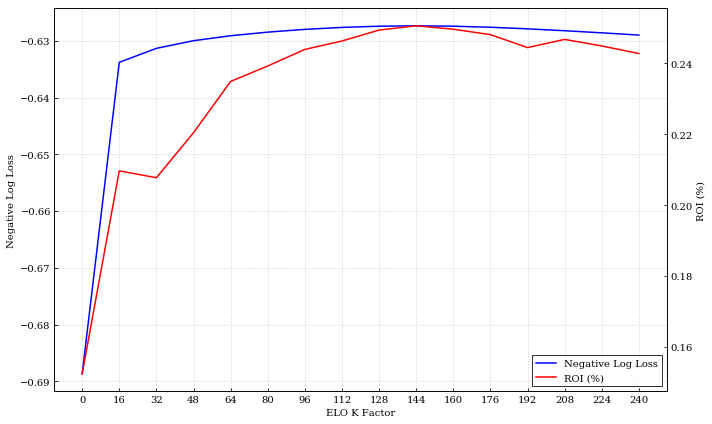

In [9]:
# Load matches_with_features using optimal k factor
matches_with_features = load_matches_with_features('matches_with_features/matches_with_features_000.csv')
matches_with_features = matches_with_features.loc[matches_with_features['date'].dt.year < 2018]

# Create time series cross validation pattern
training_set_length = len(matches_with_features)
time_cross_val = create_time_cross_val(0, training_set_length, 5)

model = LogisticRegression()

elo_features = ['average_player_elo_probability', 'team_elo_probability']
max_k_factor = 240
k_factor_range = range(0, max_k_factor+1, 16)

elo_log_loss_scores = []
elo_roi_scores = []
for k in k_factor_range:
    matches_with_elo = matches_with_features.copy()
    calculate_average_player_elo_win_probability(matches_with_elo, k)
    calculate_team_elo_win_probability(matches_with_elo, k)
    
    condensed_matches_with_elo = condense_series_matches(matches_with_elo)
    matches_odds_with_elo = add_odds_to_matches(condensed_matches_with_elo, odds)

    # Log Loss cross validation
    mean_log_loss = log_loss_cv(model, matches_with_elo, elo_features, time_cross_val)
    elo_log_loss_scores.append(mean_log_loss)
    
    # ROI cross validation
    roi_cv_scores = []
    for fold in time_cross_val:
        train_fold = matches_with_elo.loc[fold[0]]
        # test_fold = matches_with_features.loc[fold[1]]
        
        model.fit(train_fold[elo_features], train_fold['blue_win'])  
        
        matches_odds_proba = calculate_win_probabilities(matches_odds_with_elo.loc[fold[1][0]:fold[1][-1]], model, elo_features)
        
        roi_results = fixed_kelly_bet(matches_odds_proba, False, 1)
        roi_cv_scores.append(roi_results['roi'])
        
    mean_roi = sum(roi_cv_scores)/float(len(roi_cv_scores))
    elo_roi_scores.append(mean_roi)

fig = plot_log_loss_roi('ELO K Factor', k_factor_range, k_factor_range, elo_log_loss_scores, elo_roi_scores, (10, 6))

# fig.savefig('figures/elo.png', dpi=300, bbox_inches='tight')

# Optimal elo k factor we select: 144

## Finding Optimal Minimum Games

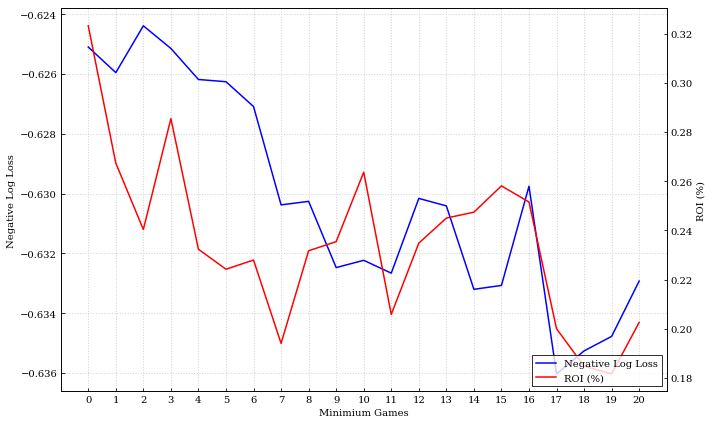

In [10]:
# Optimal k factor found from previous step
optimal_k_factor = 144

# Load matches_with_features using optimal k factor
matches_with_features = load_matches_with_features('matches_with_features/matches_with_features_000.csv')
calculate_average_player_elo_win_probability(matches_with_features, optimal_k_factor)
calculate_team_elo_win_probability(matches_with_features, optimal_k_factor)
matches_with_features = matches_with_features.loc[matches_with_features['date'].dt.year < 2018]

condensed_matches = condense_series_matches(matches_with_features)
matches_odds = add_odds_to_matches(condensed_matches, odds)

model = LogisticRegression()

max_min_games = 20
min_games_range = range(0, max_min_games+1, 1)

min_games_log_loss_scores = []
min_games_roi_scores = []
for min_games in min_games_range:
    
    matches_min_games = matches_with_features.loc[(matches_with_features['blue_games_played'] >= min_games) & (matches_with_features['red_games_played'] >= min_games)]

    # Create time series cross validation pattern - has to be regenerated each loop since the dataset reduces in size as min_games increases
    training_set_length = len(matches_min_games)
    time_cross_val = create_time_cross_val(0, training_set_length, 5)
        
    # Log Loss cross validation
    mean_log_loss = log_loss_cv(model, matches_min_games, features, time_cross_val)
    min_games_log_loss_scores.append(mean_log_loss)
    
    # ROI cross validation
    roi_cv_scores = []
    for fold in time_cross_val:
        train_fold = matches_min_games.iloc[fold[0]]
        test_lower_index = matches_min_games.index[fold[1][0]]
        test_upper_index = matches_min_games.index[fold[1][-1]]
        
        model.fit(train_fold[features], train_fold['blue_win'])  
        
        matches_odds_min_games = matches_odds.loc[(matches_odds['blue_games_played'] >= min_games) & (matches_odds['red_games_played'] >= min_games)]
        matches_odds_proba = calculate_win_probabilities(matches_odds_min_games.loc[test_lower_index:test_upper_index], model, features)

        roi_results = fixed_kelly_bet(matches_odds_proba, False, 1)
        roi_cv_scores.append(roi_results['roi'])
        
    mean_roi = sum(roi_cv_scores)/float(len(roi_cv_scores))
    min_games_roi_scores.append(mean_roi)

    
# Plot
fig = plot_log_loss_roi('Minimium Games', min_games_range, min_games_range, min_games_log_loss_scores, min_games_roi_scores, (10, 6))

# fig.savefig('figures/min_games.png', dpi=300, bbox_inches='tight')

# optimal min games we select: 0

## Finding Optimal Time Weighting Constant

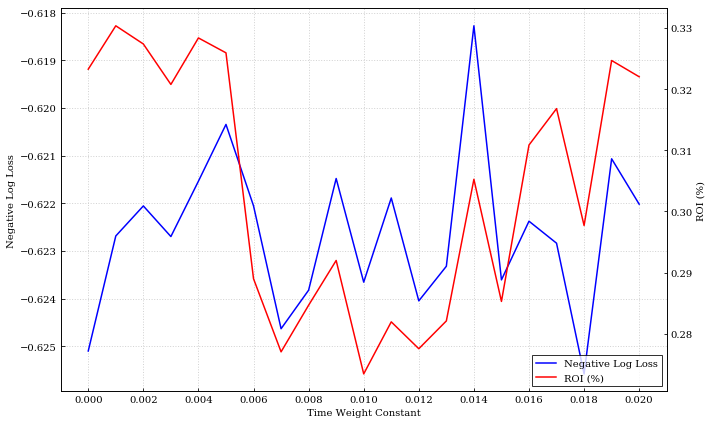

In [11]:
# Optimal parameter values found from previous steps
optimal_k_factor = 144
optimal_min_games = 0

# Loads matches_with_features for each time weighting constant applied with the optimal elo k factor
# saves you from having to run generate features for each time weighting which will take hours
matches_with_features_000 = load_matches_with_features('matches_with_features/matches_with_features_000.csv')
matches_with_features_001 = load_matches_with_features('matches_with_features/matches_with_features_001.csv')
matches_with_features_002 = load_matches_with_features('matches_with_features/matches_with_features_002.csv')
matches_with_features_003 = load_matches_with_features('matches_with_features/matches_with_features_003.csv')
matches_with_features_004 = load_matches_with_features('matches_with_features/matches_with_features_004.csv')
matches_with_features_005 = load_matches_with_features('matches_with_features/matches_with_features_005.csv')
matches_with_features_006 = load_matches_with_features('matches_with_features/matches_with_features_006.csv')
matches_with_features_007 = load_matches_with_features('matches_with_features/matches_with_features_007.csv')
matches_with_features_008 = load_matches_with_features('matches_with_features/matches_with_features_008.csv')
matches_with_features_009 = load_matches_with_features('matches_with_features/matches_with_features_009.csv')
matches_with_features_010 = load_matches_with_features('matches_with_features/matches_with_features_010.csv')
matches_with_features_011 = load_matches_with_features('matches_with_features/matches_with_features_011.csv')
matches_with_features_012 = load_matches_with_features('matches_with_features/matches_with_features_012.csv')
matches_with_features_013 = load_matches_with_features('matches_with_features/matches_with_features_013.csv')
matches_with_features_014 = load_matches_with_features('matches_with_features/matches_with_features_014.csv')
matches_with_features_015 = load_matches_with_features('matches_with_features/matches_with_features_015.csv')
matches_with_features_016 = load_matches_with_features('matches_with_features/matches_with_features_016.csv')
matches_with_features_017 = load_matches_with_features('matches_with_features/matches_with_features_017.csv')
matches_with_features_018 = load_matches_with_features('matches_with_features/matches_with_features_018.csv')
matches_with_features_019 = load_matches_with_features('matches_with_features/matches_with_features_019.csv')
matches_with_features_020 = load_matches_with_features('matches_with_features/matches_with_features_020.csv')
time_weight_datasets = [matches_with_features_000, matches_with_features_001, matches_with_features_002, matches_with_features_003, matches_with_features_004, matches_with_features_005, matches_with_features_006, matches_with_features_007, matches_with_features_008, matches_with_features_009, matches_with_features_010, matches_with_features_011, matches_with_features_012, matches_with_features_013, matches_with_features_014, matches_with_features_015, matches_with_features_016, matches_with_features_017, matches_with_features_018, matches_with_features_019, matches_with_features_020]

# For each matches_with_features dataset (with different time weightings)
for i, dataset in enumerate(time_weight_datasets):
    # Updates elos for each dataframe using optimal elo k factor
    calculate_average_player_elo_win_probability(dataset, optimal_k_factor)
    calculate_team_elo_win_probability(dataset, optimal_k_factor)
    
    # Updates each dataframe to only include games where teams have the optimal minimum games played
    time_weight_datasets[i] = dataset.loc[dataset['date'].dt.year < 2018].loc[(dataset['blue_games_played'] >= optimal_min_games) & (dataset['red_games_played'] >= optimal_min_games)].reset_index(drop=True)

# # Create time series cross validation pattern
training_set_length = len(time_weight_datasets[0])
time_cross_val = create_time_cross_val(0, training_set_length, 5)

model = LogisticRegression()
    
time_weight_constants = np.linspace(0, 0.02, 21)

time_weight_log_loss_scores = []
time_weight_roi_scores = []
for matches_time_weighting in time_weight_datasets:  
    condensed_matches_time_weighting = condense_series_matches(matches_time_weighting)
    matches_odds_time_weighting = add_odds_to_matches(condensed_matches_time_weighting, odds)
        
    # Log Loss cross validation
    mean_log_loss = log_loss_cv(model, matches_time_weighting, features, time_cross_val)
    time_weight_log_loss_scores.append(mean_log_loss)
    
    # ROI cross validation
    roi_cv_scores = []
    for fold in time_cross_val:
        train_fold = matches_time_weighting.loc[fold[0]]
        # test_fold = matches_time_weighting.loc[fold[1]]
        
        model.fit(train_fold[features], train_fold['blue_win'])  
        
        matches_odds_proba = calculate_win_probabilities(matches_odds_time_weighting.loc[fold[1][0]:fold[1][-1]], model, features)
        
        roi_results = fixed_kelly_bet(matches_odds_proba, False, 1)
        roi_cv_scores.append(roi_results['roi'])
        
    mean_roi = sum(roi_cv_scores)/float(len(roi_cv_scores))
    time_weight_roi_scores.append(mean_roi)

fig = plot_log_loss_roi('Time Weight Constant', time_weight_constants, np.linspace(0, 0.02, 11), time_weight_log_loss_scores, time_weight_roi_scores, (10, 6))

# fig.savefig('figures/time_weight.png', dpi=300, bbox_inches='tight')

# Optimal time weight we select: 0.005

## Selecting Optimal Subset of Features

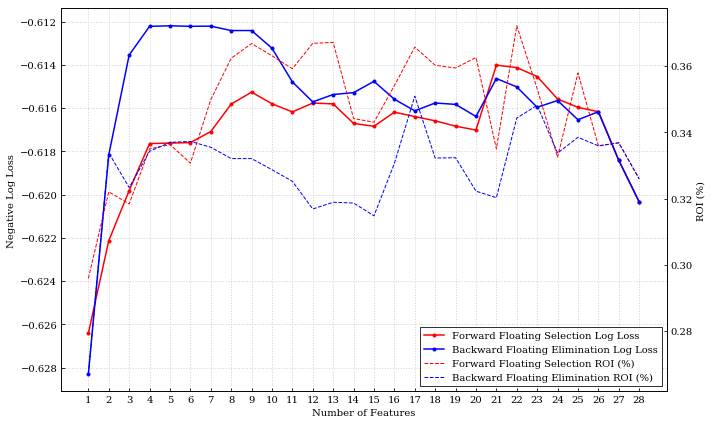

['average_player_elo_probability', 'first_to_three_towers_rate_diff', 'dragon_control_rate_diff', 'average_gold_spent_difference_diff']


In [12]:
optimal_k_factor = 144
optimal_min_games = 0
optimal_time_weight_constant = 0.005

# Loads matches_with_features with optimal elo k factor and time weighting from file
matches_with_features = load_matches_with_features('matches_with_features/matches_with_features_005.csv')
calculate_average_player_elo_win_probability(matches_with_features, optimal_k_factor)
calculate_team_elo_win_probability(matches_with_features, optimal_k_factor)
matches_with_features = matches_with_features.loc[matches_with_features['date'].dt.year < 2018].loc[(matches_with_features['blue_games_played'] >= optimal_min_games) & (matches_with_features['red_games_played'] >= optimal_min_games)].reset_index(drop=True)

condensed_matches = condense_series_matches(matches_with_features)
matches_odds = add_odds_to_matches(condensed_matches, odds)

# Create time series cross validation pattern
training_set_length = len(matches_with_features)
time_cross_val = create_time_cross_val(0, training_set_length, 5)

model = LogisticRegression()

# Run feature selection algorithms
forward = SequentialFeatureSelector(model, k_features='best', forward=True, floating=True, verbose=0, scoring='neg_log_loss', cv=time_cross_val, n_jobs=-1)
forward = forward.fit(matches_with_features[features].values, matches_with_features['blue_win'].values, custom_feature_names=features)
forward_scores = [forward.get_metric_dict()[i]['avg_score'] for i in range(1, len(features)+1)]

backward = SequentialFeatureSelector(model, k_features='best', forward=False, floating=True, verbose=0, scoring='neg_log_loss', cv=time_cross_val, n_jobs=-1)
backward = backward.fit(matches_with_features[features].values, matches_with_features['blue_win'].values, custom_feature_names=features)
backward_scores = [backward.get_metric_dict()[i]['avg_score'] for i in range(1, len(features)+1)]

# Forward Float Selection ROI cross validation
forward_roi_scores = []
for n_features in forward.subsets_:
    current_features = list(forward.subsets_[n_features]['feature_names'])
    
    roi_cv_scores = []
    for fold in time_cross_val:
        train_fold = matches_with_features.loc[fold[0]]
        
        model.fit(train_fold[current_features], train_fold['blue_win'])  
        
        matches_odds_proba = calculate_win_probabilities(matches_odds.loc[fold[1][0]:fold[1][-1]], model, current_features)
        
        roi_results = fixed_kelly_bet(matches_odds_proba, False, 1)
        roi_cv_scores.append(roi_results['roi'])
        
    mean_roi = sum(roi_cv_scores)/float(len(roi_cv_scores))
    forward_roi_scores.append(mean_roi)

# Backward Float Elimination ROI cross validation
backward_roi_scores = []
for n_features in backward.subsets_:
    current_features = list(backward.subsets_[n_features]['feature_names'])
    
    # ROI cross validation
    roi_cv_scores = []
    for fold in time_cross_val:
        train_fold = matches_with_features.loc[fold[0]]
        
        model.fit(train_fold[current_features], train_fold['blue_win'])  
        
        matches_odds_proba = calculate_win_probabilities(matches_odds.loc[fold[1][0]:fold[1][-1]], model, current_features)
        
        roi_results = fixed_kelly_bet(matches_odds_proba, False, 1)
        roi_cv_scores.append(roi_results['roi'])
        
    mean_roi = sum(roi_cv_scores)/float(len(roi_cv_scores))
    backward_roi_scores.append(mean_roi)

# Plot
fig, ax1 = plt.subplots()
plt.grid(color='lightgrey', linestyle=':', linewidth=1) 
# x axis
ax1.set_xlabel('Number of Features')
plt.xticks(range(1, len(features)+1))
ax1.tick_params(axis='x', direction='in')
# y axis (log loss)
ax1.set_ylabel('Negative Log Loss')
ax1.plot(range(1, len(features)+1), forward_scores, label='Forward Floating Selection Log Loss', color='red', marker='.')
ax1.plot(range(1, len(features)+1), backward_scores, label='Backward Floating Elimination Log Loss', color='blue', marker='.')
ax1.tick_params(axis='y', direction='in')
# y axis 2 (roi)
ax2 = ax1.twinx()
ax2.set_ylabel('ROI (%)')
ax2.plot(range(1, len(features)+1), forward_roi_scores, label='Forward Floating Selection ROI (%)', linewidth=1, linestyle='--', color='red')
ax2.plot(range(1, len(features)+1), backward_roi_scores, label='Backward Floating Elimination ROI (%)', linewidth=1, linestyle='--', color='blue')
ax2.tick_params(axis='y', direction='in')
# legend
lines = ax1.get_lines() + ax2.get_lines()
plt.legend(lines, [line.get_label() for line in lines], loc='lower right')
# final
fig.set_size_inches(10, 6)
fig.tight_layout()
plt.show()

# fig.savefig('figures/features.png', dpi=300, bbox_inches='tight')

# The features we select2
print list(backward.subsets_[4]['feature_names']) # ['average_player_elo_probability', 'first_tower_rate_diff', 'first_to_three_towers_rate_diff', 'dragon_control_rate_diff', 'average_gold_spent_difference_diff']


# Optimising C

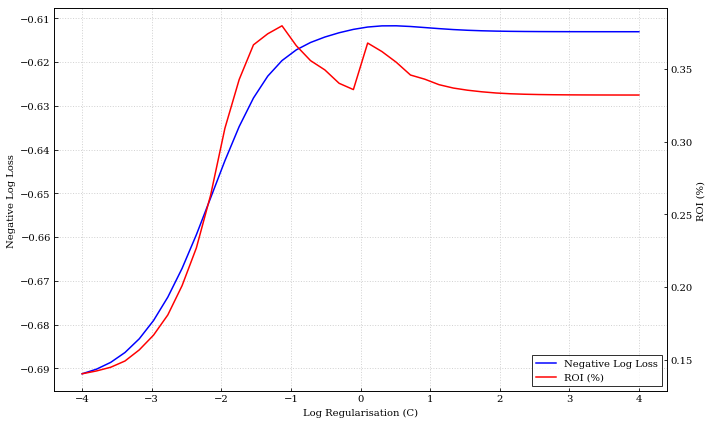

1.2663801734674023


In [13]:
optimal_k_factor = 144
optimal_min_games = 0
optimal_time_weight_constant = 0.005
selected_features = ['average_player_elo_probability', 'first_to_three_towers_rate_diff', 'dragon_control_rate_diff', 'average_gold_spent_difference_diff']

# Loads matches_with_features with optimal elo k factor and time weighting from file
matches_with_features = load_matches_with_features('matches_with_features/matches_with_features_005.csv')
calculate_average_player_elo_win_probability(matches_with_features, optimal_k_factor)
calculate_team_elo_win_probability(matches_with_features, optimal_k_factor)
matches_with_features = matches_with_features.loc[matches_with_features['date'].dt.year < 2018].loc[(matches_with_features['blue_games_played'] >= optimal_min_games) & (matches_with_features['red_games_played'] >= optimal_min_games)].reset_index(drop=True)

condensed_matches = condense_series_matches(matches_with_features)
matches_odds = add_odds_to_matches(condensed_matches, odds)

# Create time series cross validation pattern
training_set_length = len(matches_with_features)
time_cross_val = create_time_cross_val(0, training_set_length, 5)

model = LogisticRegression()

parameters = {
    'C': np.logspace(-4, 4, 40),
}

c_log_loss_scores = []
c_roi_scores = []
for c_value in parameters['C']:
    model = LogisticRegression(C=c_value)
    
    # neg log loss
    mean_log_loss = log_loss_cv(model, matches_with_features, selected_features, time_cross_val)
    c_log_loss_scores.append(mean_log_loss)
    
    roi_cv_scores = []
    for fold in time_cross_val:
        train_fold = matches_with_features.loc[fold[0]]
        
        model.fit(train_fold[selected_features], train_fold['blue_win'])  
        
        matches_odds_proba = calculate_win_probabilities(matches_odds.loc[fold[1][0]:fold[1][-1]], model, selected_features)
        
        roi_results = fixed_kelly_bet(matches_odds_proba, False, 1)
        roi_cv_scores.append(roi_results['roi'])
        
    mean_roi = sum(roi_cv_scores)/float(len(roi_cv_scores))
    c_roi_scores.append(mean_roi)

optimised_c = parameters['C'][c_log_loss_scores.index(max(c_log_loss_scores))]

# Plot
fig = plot_log_loss_roi('Log Regularisation (C)', np.log10(parameters['C']), range(-4, 9, 1), c_log_loss_scores, c_roi_scores, (10, 6))


# fig.savefig('figures/c.png', dpi=300, bbox_inches='tight')

# The C value we select
print np.logspace(-4, 4, 40)[20] # 1.2663801734674023


## Final Model Scores
Trains the model on the full training data using the optimal parameters and tests on test data

note: the log loss produced here and the value in the paper are different because this is log loss on all individual games, the log loss in the paper is the log loss for considering best-of series matches. the log loss value shown in the paper is calculated further down.

In [14]:
# Final model test score
optimal_k_factor = 144
optimal_min_games = 0
optimal_time_weight_constant = 0.005
selected_features = ['average_player_elo_probability', 'first_to_three_towers_rate_diff', 'dragon_control_rate_diff', 'average_gold_spent_difference_diff']
optimal_c = 1.2663801734674023

# Loads matches_with_features with optimal elo k factor and time weighting from file
matches_with_features = load_matches_with_features('matches_with_features/matches_with_features_005.csv')
calculate_average_player_elo_win_probability(matches_with_features, optimal_k_factor)
calculate_team_elo_win_probability(matches_with_features, optimal_k_factor)
matches_with_features = matches_with_features.loc[(matches_with_features['blue_games_played'] >= optimal_min_games) & (matches_with_features['red_games_played'] >= optimal_min_games)]#.reset_index(drop=True)

condensed_matches = condense_series_matches(matches_with_features)
matches_odds = add_odds_to_matches(condensed_matches, odds)

# Train Test Split
split = matches_with_features.index[len(matches_with_features.loc[matches_with_features['date'].dt.year < 2018])]

model = LogisticRegression(C=optimal_c)

model.fit(matches_with_features[selected_features].loc[:split-1], matches_with_features['blue_win'].loc[:split-1])

# Log Loss
test_pred = model.predict_proba(matches_with_features[selected_features].loc[split:])
print "Log Loss:", log_loss(matches_with_features['blue_win'].loc[split:], test_pred)

# ROI
matches_odds_proba = calculate_win_probabilities(matches_odds.loc[split:].loc[(matches_odds['blue_games_played'] >= optimal_min_games) & (matches_odds['red_games_played'] >= optimal_min_games)], model, selected_features)


print "fixed favourite bet", fixed_favourite_bet(matches_odds_proba, True, 0.2)
print "fixed +ev bet", fixed_ev_bet(matches_odds_proba, True, 0.2)
print "fixed kelly bet", fixed_kelly_bet(matches_odds_proba, True, 0.2)


Log Loss: 0.6468482287696866
fixed favourite bet {'roi': -0.007866473149492022, 'total_profit': -108.40000000000005, 'won': 443, 'lost': 246, 'n_bets': 689, 'total_staked': 13780.0}
fixed +ev bet {'roi': 0.12059130434782618, 'total_profit': 1386.800000000001, 'won': 326, 'lost': 249, 'n_bets': 575, 'total_staked': 11500.0}
fixed kelly bet {'roi': 0.16411670575491355, 'total_profit': 384.0631250622572, 'won': 326, 'lost': 249, 'n_bets': 575, 'total_staked': 2340.1830014538823}


### Distribution of Probabilities

In [15]:
def plot_proba_distribution(probabilities):
    fig, ax1 = plt.subplots()
    n, bins, patches = ax1.hist(probabilities, bins=np.linspace(0, 1, 21), color='blue', edgecolor='black', linewidth=1)
    # plt.title('Model Predicted Win Probability')

    # x axis
    plt.xticks(np.linspace(0, 1, 11))
    ax1.tick_params(axis='x', direction='in', top=True)
    ax1.set_xlabel('Blue Team Win Probability')

    # y axis 1
    ax1.set_ylabel('Frequency')
    ax1.tick_params(axis='y', direction='in', right=True)

    fig.set_size_inches(4, 4)

    fig.tight_layout()
    plt.show()
    
    return fig

In [16]:
condensed_matches = condense_series_matches(matches_with_features)
matches_odds = add_odds_to_matches(condensed_matches, odds)

matches_odds_proba = calculate_win_probabilities(matches_odds.loc[matches_odds['date'].dt.year == 2018], model, selected_features)

### Model Predicted Probabilities

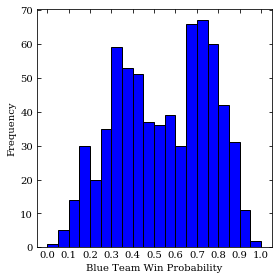

In [17]:
predicted_proba = matches_odds_proba['blue_team_series_win_proba'].fillna(matches_odds_proba['blue_team_blue_win_proba']).loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)]

fig = plot_proba_distribution(predicted_proba)

# fig.savefig('figures/model_proba.png', dpi=300, bbox_inches='tight')


### Bookmaker Odds Implied Probabilities

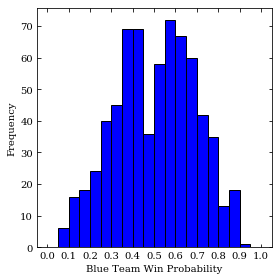

In [18]:
def get_blue_implied_proba(row):
    blue_odds = row['blue_team_odds'][-1]
    red_odds = row['red_team_odds'][-1]
    
    return (1/blue_odds)/((1/blue_odds)+(1/red_odds))

implied_proba = matches_odds_proba.loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)].apply(get_blue_implied_proba, axis=1)

fig = plot_proba_distribution(implied_proba)

# fig.savefig('figures/odds_proba.png', dpi=300, bbox_inches='tight')


### Elo Model Implied Probabilities

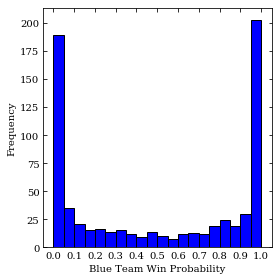

In [19]:
elo_proba = matches_odds_proba['average_player_elo_probability'].loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)]

fig = plot_proba_distribution(elo_proba)

# fig.savefig('figures/elo_proba.png', dpi=300, bbox_inches='tight')


### Comparisons

In [21]:
#matches_odds_proba = calculate_win_probabilities(matches_odds.loc[matches_odds['date'].dt.year == 2018], model, selected_features)

def check_model_prediction(row):
    if row['series_length'] == 1:
        if (row['blue_team_blue_win_proba'] > 0.5 and row['blue_series_win'] == True) or (row['blue_team_blue_win_proba'] < 0.5 and row ['blue_series_win'] == False):
            return True
    elif row['series_length'] > 1:
        if (row['blue_team_series_win_proba'] > 0.5 and row['blue_series_win'] == True) or (row['blue_team_series_win_proba'] < 0.5 and row ['blue_series_win'] == False):
            return True
    
    return False

def check_bookmaker_prediction(row):
    blue_win_proba = get_blue_implied_proba(row)
    
    if (blue_win_proba > 0.5 and row['blue_series_win'] == True) or (blue_win_proba < 0.5 and row['blue_series_win'] == False):
        return True
            
    return False

def check_elo_prediction(row):
    
    if (row['average_player_elo_probability'] > 0.5 and row['blue_series_win'] == True) or (row['average_player_elo_probability'] < 0.5 and row['blue_series_win'] == False):
        return True

    return False

# accuracy
# predicted = matches_odds_proba.fillna(matches_odds_proba['blue_team_blue_win_proba']).loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)].loc[matches_odds_proba.apply(check_model_prediction, axis=1)]

# implied = matches_odds_proba.loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)]
# implied = implied.loc[implied.apply(check_bookmaker_prediction, axis=1)]

# log loss
predicted_proba = matches_odds_proba['blue_team_series_win_proba'].fillna(matches_odds_proba['blue_team_blue_win_proba']).loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)]

implied_proba = matches_odds_proba.loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)].apply(get_blue_implied_proba, axis=1)

elo = matches_odds_proba.loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)].loc[matches_odds_proba.apply(check_elo_prediction, axis=1)]
elo_proba = matches_odds_proba['average_player_elo_probability'].loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)]


actual = matches_odds_proba['blue_series_win'].loc[matches_odds_proba['blue_team_odds'].apply(lambda x: len(x) > 0)].apply(lambda x: int(x))


print "bookmaker accuracy", len(implied), "/", len(implied_proba)
print "model accuracy", len(predicted), "/", len(predicted_proba)
print "elo accuracy", len(elo), "/", len(elo_proba)
print ""
print "bookmaker log loss", log_loss(actual, implied_proba)
print "model log loss", log_loss(actual, predicted_proba)
print "elo log loss", log_loss(actual, elo_proba)
print ""
print "average bookmaker probability", implied_proba.sum()/float(len(implied_proba))
print "average predicted probability", predicted_proba.sum()/float(len(predicted_proba))
print "average elo probability", elo_proba.sum()/float(len(elo_proba))

 bookmaker accuracy

NameError: name 'implied' is not defined

### Code used to generate matches_with_features csvs

In [ ]:
# matches_with_features_000 = generate_features(matches_no_features, 0, 0)
# matches_with_features_001 = generate_features(matches_no_features, 0.001, 0)
# matches_with_features_002 = generate_features(matches_no_features, 0.002, 0)
# matches_with_features_003 = generate_features(matches_no_features, 0.003, 0)
# matches_with_features_004 = generate_features(matches_no_features, 0.004, 0)
# matches_with_features_005 = generate_features(matches_no_features, 0.005, 0)
# matches_with_features_006 = generate_features(matches_no_features, 0.006, 0)
# matches_with_features_007 = generate_features(matches_no_features, 0.007, 0)
# matches_with_features_008 = generate_features(matches_no_features, 0.008, 0)
# matches_with_features_009 = generate_features(matches_no_features, 0.009, 0)
# matches_with_features_010 = generate_features(matches_no_features, 0.01, 0)
# matches_with_features_011 = generate_features(matches_no_features, 0.011, 0)
# matches_with_features_012 = generate_features(matches_no_features, 0.012, 0)
# matches_with_features_013 = generate_features(matches_no_features, 0.013, 0)
# matches_with_features_014 = generate_features(matches_no_features, 0.014, 0)
# matches_with_features_015 = generate_features(matches_no_features, 0.015, 0)
# matches_with_features_016 = generate_features(matches_no_features, 0.016, 0)
# matches_with_features_017 = generate_features(matches_no_features, 0.017, 0)
# matches_with_features_018 = generate_features(matches_no_features, 0.018, 0)
# matches_with_features_019 = generate_features(matches_no_features, 0.019, 0)
# matches_with_features_020 = generate_features(matches_no_features, 0.02, 0)

In [ ]:
# matches_with_features_000.to_csv('matches_with_features/matches_with_features_000.csv', index=False)
# matches_with_features_001.to_csv('matches_with_features/matches_with_features_001.csv', index=False)
# matches_with_features_002.to_csv('matches_with_features/matches_with_features_002.csv', index=False)
# matches_with_features_003.to_csv('matches_with_features/matches_with_features_003.csv', index=False)
# matches_with_features_004.to_csv('matches_with_features/matches_with_features_004.csv', index=False)
# matches_with_features_005.to_csv('matches_with_features/matches_with_features_005.csv', index=False)
# matches_with_features_006.to_csv('matches_with_features/matches_with_features_006.csv', index=False)
# matches_with_features_007.to_csv('matches_with_features/matches_with_features_007.csv', index=False)
# matches_with_features_008.to_csv('matches_with_features/matches_with_features_008.csv', index=False)
# matches_with_features_009.to_csv('matches_with_features/matches_with_features_009.csv', index=False)
# matches_with_features_010.to_csv('matches_with_features/matches_with_features_010.csv', index=False)
# matches_with_features_011.to_csv('matches_with_features/matches_with_features_011.csv', index=False)
# matches_with_features_012.to_csv('matches_with_features/matches_with_features_012.csv', index=False)
# matches_with_features_013.to_csv('matches_with_features/matches_with_features_013.csv', index=False)
# matches_with_features_014.to_csv('matches_with_features/matches_with_features_014.csv', index=False)
# matches_with_features_015.to_csv('matches_with_features/matches_with_features_015.csv', index=False)
# matches_with_features_016.to_csv('matches_with_features/matches_with_features_016.csv', index=False)
# matches_with_features_017.to_csv('matches_with_features/matches_with_features_017.csv', index=False)
# matches_with_features_018.to_csv('matches_with_features/matches_with_features_018.csv', index=False)
# matches_with_features_019.to_csv('matches_with_features/matches_with_features_019.csv', index=False)
# matches_with_features_020.to_csv('matches_with_features/matches_with_features_020.csv', index=False)